### Poisonous vs. Edible Mushroom Classification 

#### Synopsis
The following analysis will explore the kaggle Mushroom Classification dataset (https://www.kaggle.com/uciml/mushroom-classification). Several ML models will be explored for their ability to classify mushrooms as poisonous or edible based off of the provided data. 

Both unsupervised and supervised methods will be used, as well as regression and ensemble methods for a rounded look at how different models work with categorical datasets. 

#### Mushrooms:
Mushrooms come in all shapes, sizes, colours, and flavours--as the saying goes: every mushroom is edible at least <i>once</i>.

Mushroom identification is a multifaceted process, where several important features of the fruiting body are taken into account before determining edibility. In addition to physical factors, the time of season and where a mushroom fruits (dirt, grass, manure, on a tree, on a fallen log, etc.) are also important considerations when id'ing fungi. Id'ing should always be done by an experienced mushroom hunter with local knowledge. 

#### Quick Poisonous Mushroom Identifiers
* Spore Print: Spores are collected by placing a mushroom cap facedown over a sheet of paper or mirror. Different species' spores will be specific shades/colours, for example genus <a href="https://en.wikipedia.org/wiki/Amanita"><i>Amanita</i></a> will spore print white--poison. 
* Fruiting Body: Several dispersal mechanisms for spores have evolved; between gilled, porous, sac or puffball fungi poisonous species may all mimic edible look-a-likes. 
* Bruising/Color: Certain species that bruise dark when handled can sometimes indicate poison or inedibility. 
* Morphology: 
   * The genus <a href="https://en.wikipedia.org/wiki/Amanita"><i>Amanita</i></a> carries some of the some deadliest mushrooms in the world. Destroying Angel, Death Cap and Fool's Mushroom are all fatal, however share characteristics of the Amanita class making them easily identifiable. While the cap colour may alter, typically White cap, gills, and spore print, along with a physical structure called the volva are telltale signs of  <a href="https://en.wikipedia.org/wiki/Amanita"><i>Amanita's</i></a>. 
   <img src="https://atrium.lib.uoguelph.ca/xmlui/bitstream/handle/10214/6850/Amanita_virosa_Destroying_Angel_amanitin_and_phalloidin.jpg?sequence=1&isAllowed=y" alt="Identifying a Destroying angel" width="40%"></img>
   <div align="center"><small>Source: University of Guelph</small></div>
   * The genus <a href="https://en.wikipedia.org/wiki/Gyromitra_esculenta"><i>Gyromitra</i></a>, better known as the False Morel, is an example of a poisonous mushroom that looks like the famously delicious Morel. Inexperienced mushroom hunters could potentially mix this type of mushroom up with an edible counterpart and suffer the consequences. However, false morels have a full stem and are tellingly <i>not</i> hollow. 
   <img src="https://cdn0.wideopenspaces.com/wp-content/uploads/2017/03/morel-mushroom-real-fake.jpg" alt="Two true morels on the left, false morel on the right" width="50%"></img>
   <div align="center"><small><a href="https://www.wideopenspaces.com/learn-important-difference-real-false-morel-mushrooms/">Source: Wide Open Spaces</a></small></div>

Let's first import packages and data.

In [102]:
#import cleaning and visualization modules
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams, gridspec

#import analysis modules
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn import linear_model
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

#warning configuration
import warnings
warnings.filterwarnings('ignore')

Data is read into a dataframe and displayed. Next dataypes, counts and columns are shown and a check if any null values are present.

In [103]:
#read into dataframe, display first 5 values
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [104]:
#Look into df for datatypes, if nulls exist 
null_count = 0
for val in df.isnull().sum():
    null_count += val
print('There are {} null values.\n'.format(null_count))
df.info()

There are 0 null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 n

We've seen that the data is categorical and there are no nulls in our set. Let's check how many classes are in each column.

In [105]:
def show_features(df):
    '''Takes a dataframe and outputs the columns, number of classes and category variables.'''
    col_count, col_var = [], []
    for col in df:
        col_count.append(len(df[col].unique()))
        col_var.append(df[col].unique().sum())
    df_dict = {'Count': col_count, 'Variables': col_var}
    df_table = pd.DataFrame(df_dict, index=df.columns)
    print(df_table)
    
show_features(df)

                          Count     Variables
class                         2            pe
cap-shape                     6        xbsfkc
cap-surface                   4          syfg
cap-color                    10    nywgepbucr
bruises                       2            tf
odor                          9     palnfcysm
gill-attachment               2            fa
gill-spacing                  2            cw
gill-size                     2            nb
gill-color                   12  kngpwhuebryo
stalk-shape                   2            et
stalk-root                    5         ecbr?
stalk-surface-above-ring      4          sfky
stalk-surface-below-ring      4          sfyk
stalk-color-above-ring        9     wgpnbeocy
stalk-color-below-ring        9     wpgbneyoc
veil-type                     1             p
veil-color                    4          wnoy
ring-number                   3           otn
ring-type                     5         pelfn
spore-print-color             9   

Right away there are some interesting things to note: Veil-type has only one class and can be removed from our set, several classes are binary and can be reduced to a single feature, and there is a '?' class in the stalk-root class. One-hot encoding will transform our data into a usable format for our models, remove excess feature columns and prepare our independent variable for supervised learning. 

Next, let's see how many '?' values are present in the stalk-root category.

In [106]:
df['stalk-root'].value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64

There are a few options--remove the class entirely but lose potential information in our dataset, delete any row with a '?' but lose data across all variables, or encode the data and treat it as an unknown variable. For the purposes of this study we'll keep the class and use encoding to transform '?' into a feature. 

In [107]:
df_dum = pd.get_dummies(df, drop_first=True)
df_dum.head()

,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


### Mushroom Hunting & Important Features of Determining Edibility

As discussed earlier, the art of mushroom foraging can be difficult at times when ID'ing unknown species. In the field, we'll collect a spore print, look at morphological features, mark time of year, use smell, test for bruising, note the conditions it was found in: healthy or rotted terrain, neighbouring trees and plant life, near other fungi--all important steps in correctly identifying whether a find is edible or poisonous. 

We can graph some of the data to determine if there are any features that are more associated with poisonous species at a glance before running our models and testing for important features.


In [108]:
df.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

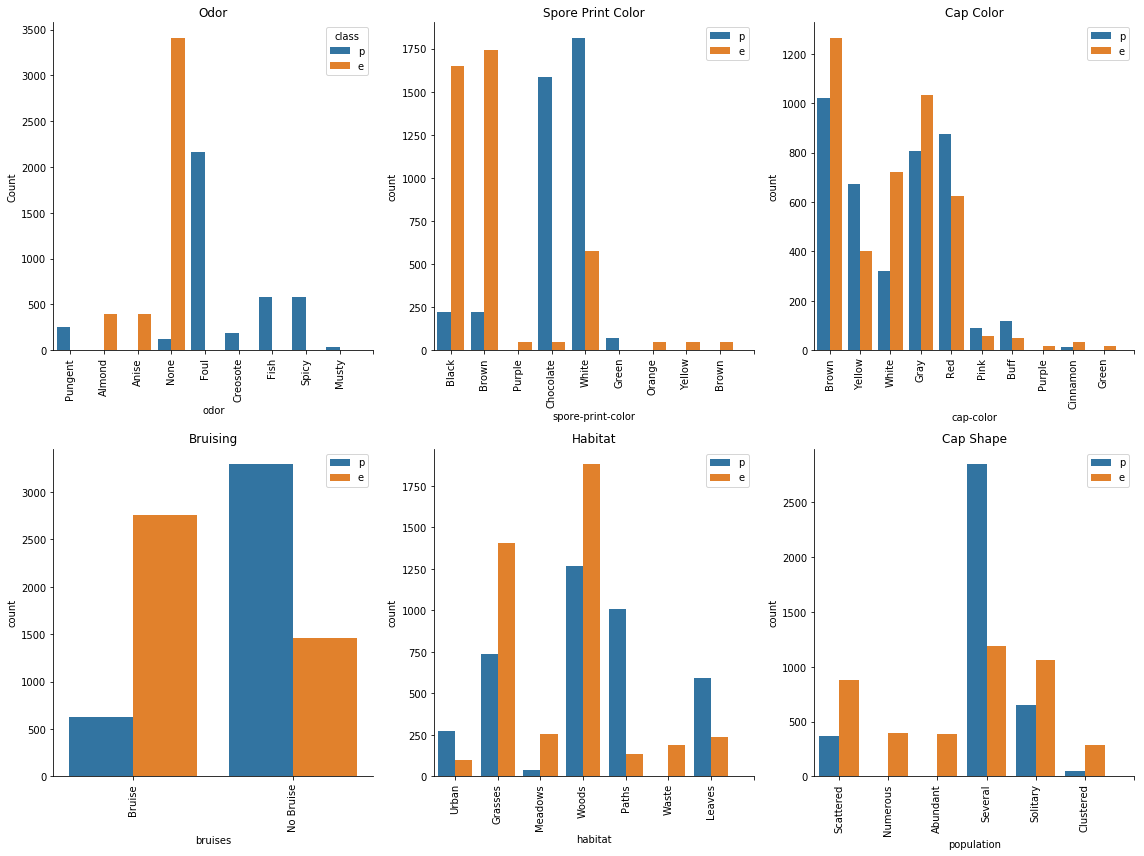

In [109]:
plt.figure(figsize=[16,12])

plt.subplot(231)
sns.countplot(x='odor', hue='class', data=df)
plt.title('Odor')
plt.xticks(np.arange(10),('Pungent', 'Almond', 'Anise', 'None', 'Foul', 'Creosote', 'Fish', 'Spicy', 'Musty'), rotation='vertical')
plt.ylabel('Count')

plt.subplot(232)
sns.countplot(x='spore-print-color', hue='class', data=df)
plt.title('Spore Print Color')
plt.xticks(np.arange(10),('Black', 'Brown','Purple','Chocolate','White','Green','Orange','Yellow','Brown'), rotation='vertical')
plt.legend(loc='upper right')

plt.subplot(233)
sns.countplot(x='cap-color', hue='class', data=df)
plt.title('Cap Color')
plt.xticks(np.arange(11),('Brown', 'Yellow','White','Gray','Red','Pink','Buff','Purple','Cinnamon','Green'), rotation='vertical')
plt.legend(loc='upper right')

plt.subplot(234)
sns.countplot(x='bruises', hue='class', data=df)
plt.title('Bruising')
plt.xticks(np.arange(2),('Bruise', 'No Bruise'), rotation='vertical')
plt.legend(loc='upper right')

plt.subplot(235)
sns.countplot(x='habitat', hue='class', data=df)
plt.title('Habitat')
plt.xticks(np.arange(8),('Urban', 'Grasses','Meadows','Woods','Paths','Waste','Leaves'), rotation='vertical')
plt.legend(loc='upper right')

plt.subplot(236)
sns.countplot(x='population', hue='class', data=df)
plt.title('Cap Shape')
plt.xticks(np.arange(7),('Scattered', 'Numerous','Abundant','Several','Solitary','Clustered'), rotation='vertical')
plt.legend(loc='upper right')

plt.tight_layout()
sns.despine()

In [175]:
#set features
X = df_dum.drop('class_p', axis=1)
#set independent variable
y = df_dum['class_p']
#split the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#print shapes of training/testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5686, 95) (2438, 95) (5686,) (2438,)


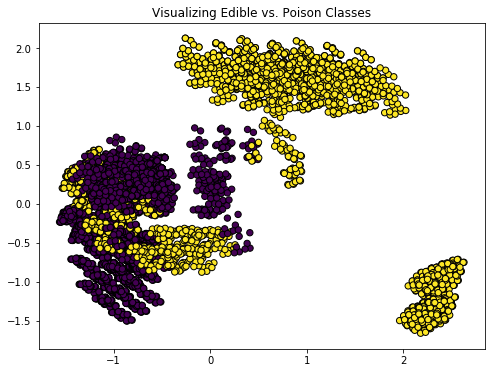

In [176]:
#visualize edible vs poison classes
pca = PCA(n_components=2)

x_pca = X.values
x_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=y, s=40, edgecolor='k')
plt.title('Visualizing Edible vs. Poison Classes');

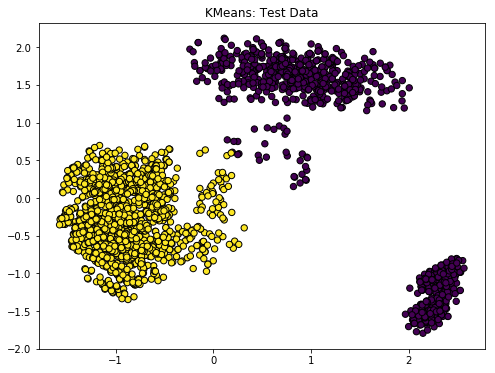

In [194]:
from sklearn import metrics
from sklearn.cluster import KMeans

#Specify the model and fit to training set
km = KMeans(n_clusters = 2)
km.fit(X_train)

#PCA X_test for visualization
pca_test = PCA(n_components = 2)
pca_test.fit(X_test)
X_test_pca = X_test.values
X_test_pca = pca_test.fit_transform(X_test)

#KMeans prediction
y_pred_km = km.predict(X_test)

#Plot the data
plt.figure(figsize=(8,6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_km, 
            s=40, edgecolor='k')
plt.title('KMeans: Test Data')
plt.show();

In [197]:
def plot_confusion_matrix(cm, classes, fontsize=15,
                          normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm_num = cm
    cm_per = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot perentage
        text = format(cm_per[i, j], '.5f')
        text = text + '%'
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='baseline',
            horizontalalignment='center',
            color=color)
        # Plot numeric
        text = format(cm_num[i, j], 'd')
        text = '\n \n' + text
        plt.text(j, i,
            text,
            fontsize=fontsize,
            verticalalignment='center',
            horizontalalignment='center',
            color=color)
        
    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return None

In [208]:
y_pred_km

array([1, 0, 0, ..., 0, 0, 1])

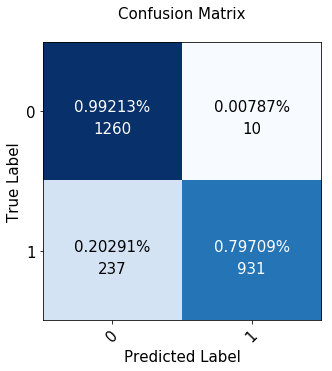

In [210]:
cm_km = metrics.confusion_matrix(y_test,1-y_pred_km)
plot_confusion_matrix(cm_km, classes=[0,1])

In [190]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_km)

0.10131255127153405

Next, Logistic Regression

In [6]:
#logistic regression
log_model = linear_model.LogisticRegression()
log_model.fit(X_train, y_train)
log_probs = log_model.predict_proba(X_test)
loss = log_loss(y_test, log_probs)
print('Loss value: {}'.format(loss))
print('Training accuracy: {}%'.format(log_model.score(X_train, y_train)))
print('Test accuracy: {}%'.format(log_model.score(X_test, y_test)))

Loss value: 0.008853782721418119
Training accuracy: 0.9996482588814632%
Test accuracy: 0.9987694831829368%


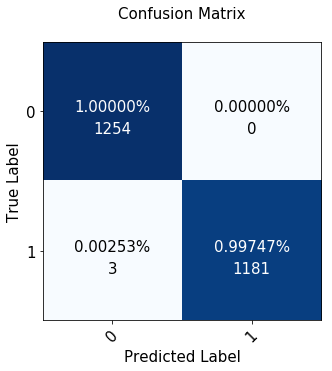

In [84]:
predictions = log_model.predict(X_test)

cm = metrics.confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, [0,1])

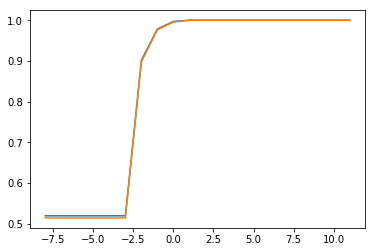

<Figure size 864x576 with 0 Axes>

In [75]:
#SVM checking C
train = []
test = []

value_range = [0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,\
               1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000,100000000000]
#loop through vaues of C
for i in value_range :
    svm = SVC(C=i)
    svm.fit(X_train, y_train)
    train.append(svm.score(X_train, y_train))
    test.append(svm.score(X_test, y_test))

#plot out results
plt.plot(np.log10(value_range),train)
plt.plot(np.log10(value_range),test)
plt.figure(figsize=(12,8))
plt.show();

In [77]:
#test out different SVMs using the different kernals
kerns = ['linear', 'rbf', 'sigmoid']
for i in kerns:
    #Kernel trick
    svm_kern = SVC(C=0.01, kernel='{}'.format(i))
    svm_kern.fit(X_train,y_train)
    
    #Get the score
    print('{0} Kernal SVM score: {1}'.format(i, (100*svm_kern.score(X_test,y_test))))

linear Kernal SVM score: 98.44134536505332
rbf Kernal SVM score: 89.78671041837572
sigmoid Kernal SVM score: 89.49958982772765


In [78]:
#fit SVM model to scaled data
svm = LinearSVC(C=0.01)
svm.fit(X_train, y_train)
print('The normalized training accuracy is: {}%'.format(svm.score(X_train, y_train)))
print('The normalized test accuracy is: {}%'.format(svm.score(X_test, y_test)))

The normalized training accuracy is: 0.9980654238480479%
The normalized test accuracy is: 0.9967186218211649%


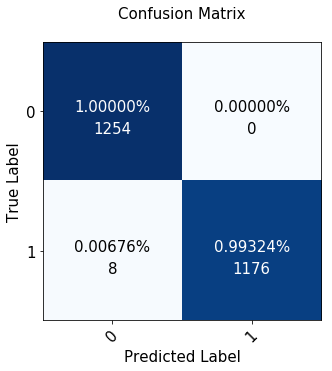

In [80]:
pred_svm = svm.predict(X_test)

cm_svm = metrics.confusion_matrix(y_test, pred_svm)
plot_confusion_matrix(cm_svm, [0,1])

In [12]:
gb = GradientBoostingClassifier()
xgb = XGBClassifier()

gb.fit(X_train,y_train)
xgb.fit(X_train,y_train)

print("Gradient Boost score: %3.3f" % (100 * gb.score(X_test,y_test)))
print("XG Boost score: %3.3f"       % (100 * xgb.score(X_test,y_test)))

Gradient Boost score: 100.000
XG Boost score: 100.000


c:\users\b\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


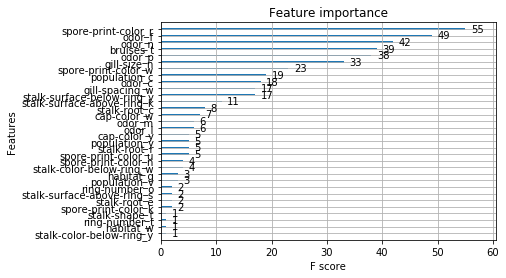

In [22]:
from xgboost import plot_importance
#look at features of 
#xgb.feature_importances_
plot_importance(xgb)
plt.show()

In [23]:
#testing out random forest  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print("Default RFR: %3.3f" % (rf.score(X_test, y_test)))

Default RFR: 1.000


In [26]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [27]:
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 100}

In [30]:
rfcv = RandomForestClassifier(criterion= 'gini',
 max_depth= 7,
 max_features= 'auto',
 n_estimators= 100)
rfcv.fit(X_train, y_train)
print("Default RFR: %3.3f" % (rfcv.score(X_test, y_test)))

Default RFR: 0.998


In [41]:
feature_imp = pd.Series(rfcv.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

odor_n                        0.188265
odor_f                        0.088653
gill-size_n                   0.088313
stalk-surface-above-ring_k    0.066053
ring-type_p                   0.054594
stalk-surface-below-ring_k    0.037901
bruises_t                     0.034448
spore-print-color_w           0.028014
population_v                  0.025850
gill-spacing_w                0.025616
stalk-surface-above-ring_s    0.024761
spore-print-color_h           0.023169
stalk-surface-below-ring_s    0.020335
odor_p                        0.020132
ring-type_l                   0.017630
stalk-root_b                  0.016677
stalk-shape_t                 0.012811
spore-print-color_k           0.012318
spore-print-color_n           0.012277
habitat_g                     0.011851
odor_y                        0.011462
habitat_u                     0.010886
stalk-root_c                  0.010643
odor_s                        0.009783
stalk-color-above-ring_w      0.009325
odor_c                   

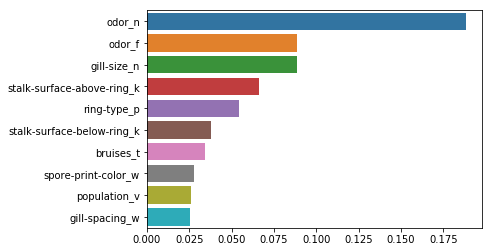

In [42]:
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])